# Fitting a Linear Simulation with XGBoost

This notebook uses shap to demonstrate how XGBoost behaves when we fit it to simulated data where the label has a linear relationship to the features.

In [1]:
import numpy as np
import scipy as sp
import xgboost
import shap
import sklearn
from sklearn.model_selection import train_test_split

## Build a simulated dataset with binary labels

In [2]:
N = 10000
M = 10
np.random.seed(0)
X = np.random.randn(N,M)
beta = np.random.randn(M)
y_margin = X @ beta
y = y_margin

X_train,X_test,y_train,y_test = train_test_split(X, y)
X_strain,X_valid,y_strain,y_valid = train_test_split(X_train, y_train)

## Build an XGBoost regressor

### Train a depth 1 model

In [3]:
model_depth1 = xgboost.XGBRegressor(max_depth=1, learning_rate=0.01, subsample=0.5, n_estimators=10000, base_score=y_strain.mean())
model_depth1.fit(X_strain, y_strain, eval_set=[(X_valid,y_valid)], eval_metric="logloss", verbose=1000, early_stopping_rounds=20)

[0]	validation_0-logloss:-1.74610
Will train until validation_0-logloss hasn't improved in 20 rounds.
[1000]	validation_0-logloss:-45.70887
Stopping. Best iteration:
[1069]	validation_0-logloss:-45.93972



XGBRegressor(base_score=0.013271975120564432, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=1, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=0,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.5, tree_method='exact',
             validate_parameters=1, verbosity=None)

### Train a depth 3 model

In [4]:
model_depth3 = xgboost.XGBRegressor(learning_rate=0.02, subsample=0.2, colsample_bytree=0.5, n_estimators=5000, base_score=y_strain.mean())
model_depth3.fit(X_strain, y_strain, eval_set=[(X_valid,y_valid)], eval_metric="logloss", verbose=500, early_stopping_rounds=20)

[0]	validation_0-logloss:-22.75916
Will train until validation_0-logloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[420]	validation_0-logloss:-49.13102



XGBRegressor(base_score=0.013271975120564432, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.02, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=5000, n_jobs=0,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.2, tree_method='exact',
             validate_parameters=1, verbosity=None)

## Explain the depth 1 model

In [5]:
shap_values = shap.TreeExplainer(model_depth1).shap_values(X_test)
shap_interaction_values = shap.TreeExplainer(model_depth1).shap_interaction_values(X_test)

### Summary bar plot shows the global importance of each feature

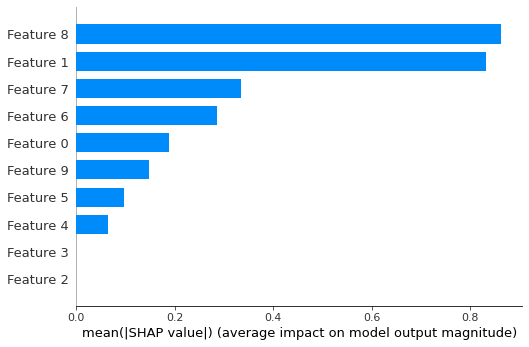

In [6]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

### Summary bee-swarm plot shows the global importance of each feature and the distribution of effect sizes

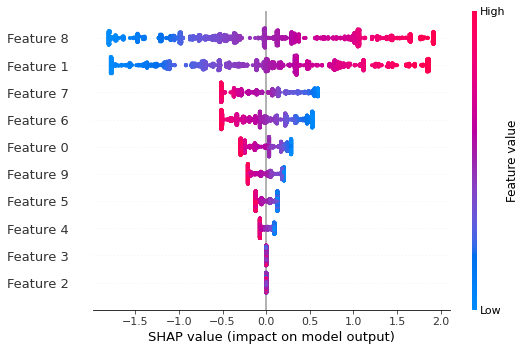

In [7]:
shap.summary_plot(shap_values, X_test)

### The dependence plot for the top feature shows that XGBoost captured most the linear relationship

It is important to note that XGBoost (and other gradient boosted tree models) is biased towards flat regions, which can be seen below by the flattened tails of the linear function.

invalid value encountered in true_divide
invalid value encountered in true_divide


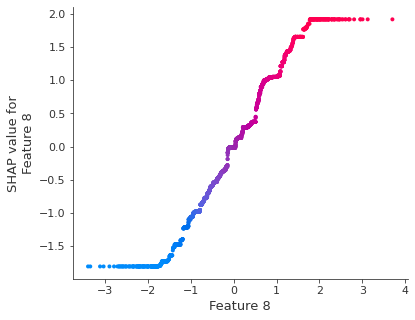

In [8]:
shap.dependence_plot(8, shap_values, X_test)

**As expected there are no interactions for the depth-1 model:**

We can also see this from the lack of any vertical dispresion in the dependence plot above.

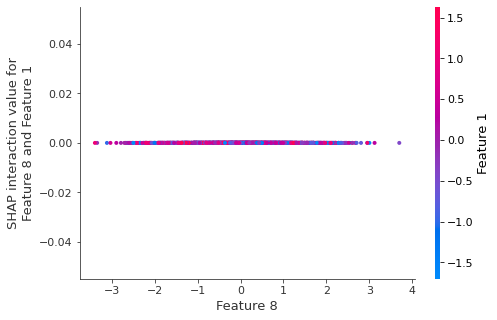

In [9]:
shap.dependence_plot((8,1), shap_interaction_values, X_test)

**The tail flattening behavior is consistent across all other features.**

invalid value encountered in true_divide
invalid value encountered in true_divide


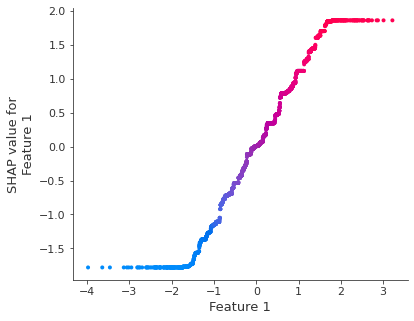

In [10]:
shap.dependence_plot(1, shap_values, X_test)

**Note that weaker signal lead to more variability in the fits:**

Since XGBoost like flat regions the variability will often look like step functions. Remember in the plot below the SHAP values are correctly telling you what the model learned, but the model did not learn a smooth line.

invalid value encountered in true_divide
invalid value encountered in true_divide


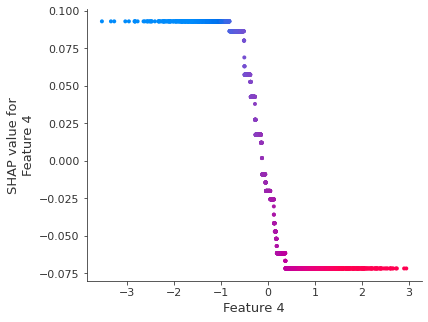

In [11]:
shap.dependence_plot(4, shap_values, X_test)

## Explain the depth 3 model

In this simulation we know that the true relationships are linear without any interactions. However when we fit trees with depth greater than 1, we are telling the model to look for interactions. When we explain our depth 3 model we see that it did learn some weak (incorrect) interactions.

In [12]:
e3 = shap.TreeExplainer(model_depth3)
shap_values3 = e3.shap_values(X_test)
shap_interaction_values3 = shap.TreeExplainer(model_depth3).shap_interaction_values(X_test)

**The bar chart of global importance is basically the same as depth 1.**

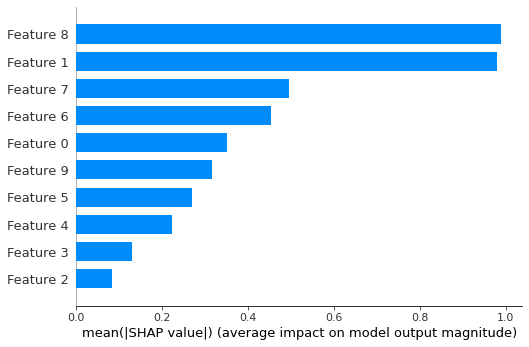

In [13]:
shap.summary_plot(shap_values3, X_test, plot_type="bar")

**The bee-swarm summary plots are smoother than with the depth 1 model (see to dependency plots for why).**

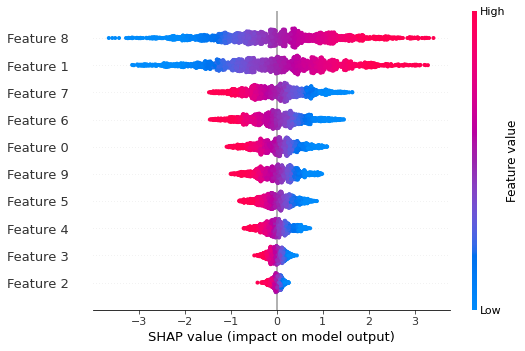

In [14]:
shap.summary_plot(shap_values3, X_test)

**The vertical interaction dispersion from the depth 3 tree smoothes over any small steps.**

This is what made the bee-swarm summary plot look more even. Note also though there when we color by feature 1 we seem to see a consistent interation effect.

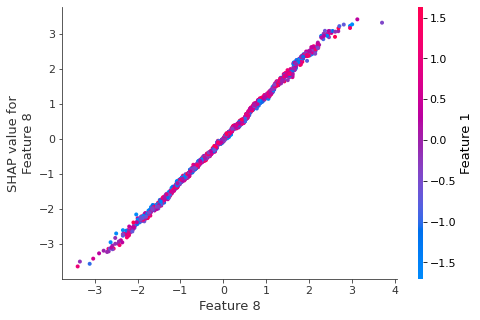

In [15]:
shap.dependence_plot(8, shap_values3, X_test)

**If we look more closely and plot the interaction value between 6 and 1 we see a seemingly clear pattern:**

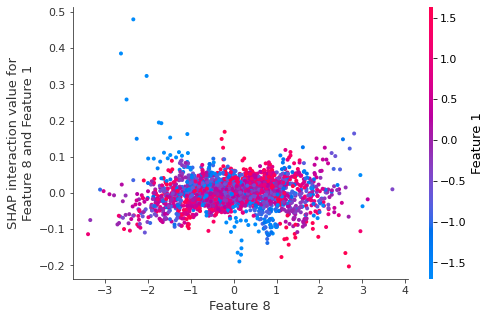

In [16]:
shap.dependence_plot((8,1), shap_interaction_values3, X_test)

**The same interaction effect is observed on a new set set:**

This means the model really did learn this interaction, even though there was no interaction there to learn. How can protect ourselves from jumping to the conclusion that this is a real interaction? (without using the fact that we simluated this data)

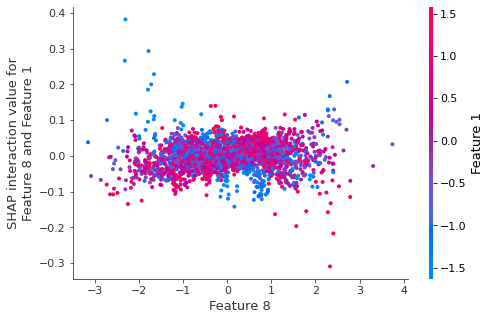

In [17]:
X_tmp = np.random.randn(*X_test.shape)
tmp_values = shap.TreeExplainer(model_depth3).shap_interaction_values(X_tmp)
shap.dependence_plot((8,1), tmp_values, X_tmp)

**The same interaction for retrained models.**

The structure (what little there was) seems to go away when we retrain the model on bootstrap resamples.

0
[0]	validation_0-logloss:-16.25149
Will train until validation_0-logloss hasn't improved in 20 rounds.
[500]	validation_0-logloss:-45.97159
Stopping. Best iteration:
[661]	validation_0-logloss:-46.14141



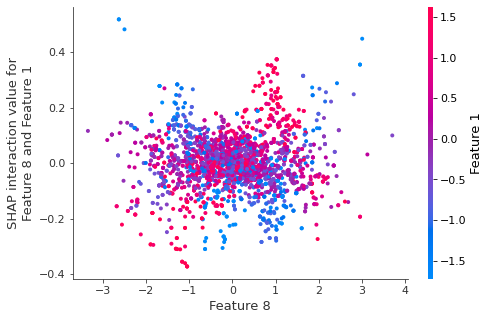

1
[0]	validation_0-logloss:-22.06177
Will train until validation_0-logloss hasn't improved in 20 rounds.
[500]	validation_0-logloss:-48.22577
Stopping. Best iteration:
[756]	validation_0-logloss:-48.56762



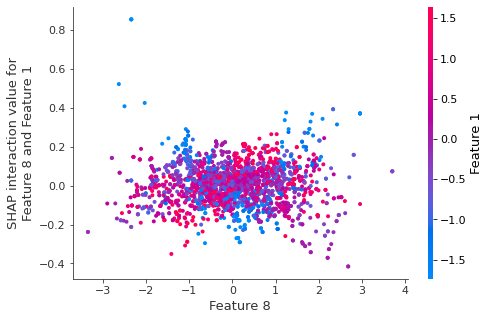

2
[0]	validation_0-logloss:-17.10220
Will train until validation_0-logloss hasn't improved in 20 rounds.
[500]	validation_0-logloss:-49.20269
Stopping. Best iteration:
[811]	validation_0-logloss:-49.75841



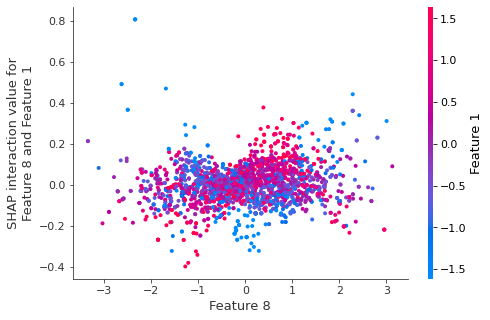

3
[0]	validation_0-logloss:-18.76660
Will train until validation_0-logloss hasn't improved in 20 rounds.
[500]	validation_0-logloss:-46.70300
Stopping. Best iteration:
[881]	validation_0-logloss:-47.18671



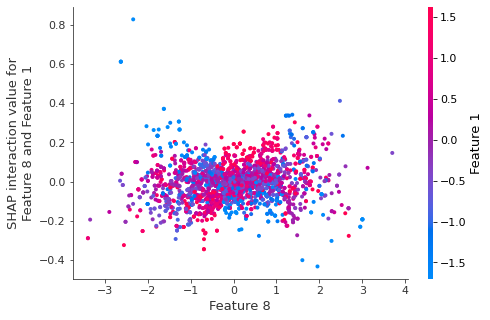

4
[0]	validation_0-logloss:-18.81784
Will train until validation_0-logloss hasn't improved in 20 rounds.
[500]	validation_0-logloss:-48.87157
Stopping. Best iteration:
[588]	validation_0-logloss:-49.16772



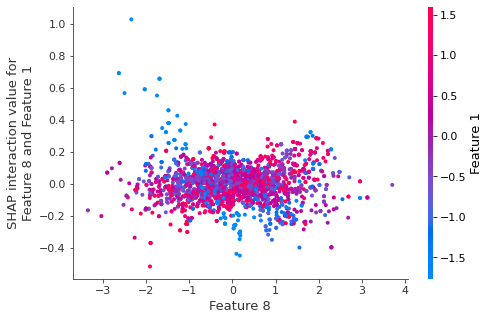

In [18]:
for i in range(5):
    print(i)
    X_strain_tmp, y_strain_tmp = sklearn.utils.resample(X_strain, y_strain)
    X_valid_tmp, y_valid_tmp = sklearn.utils.resample(X_valid, y_valid)
    X_test_tmp, y_test_tmp = sklearn.utils.resample(X_test, y_test)
    
    model_tmp = xgboost.XGBRegressor(learning_rate=0.01, subsample=0.5, n_estimators=5000, base_score=y_strain.mean())
    model_tmp.fit(X_strain_tmp, y_strain_tmp, eval_set=[(X_valid_tmp, y_valid_tmp)], eval_metric="logloss", verbose=500, early_stopping_rounds=20)
    
    tmp_values = shap.TreeExplainer(model_tmp).shap_interaction_values(X_test_tmp)
    shap.dependence_plot((8,1), tmp_values, X_test_tmp)

### Visualize a single prediction

In [19]:
shap.initjs()

In [20]:
e3 = shap.TreeExplainer(model_depth3)
t = e3.shap_values(X_test)

In [21]:
shap.force_plot(e3.expected_value, shap_values[0,:], X_test[0,:])

In [22]:
shap.force_plot(e3.expected_value, shap_values[0:500,:], X_test[0:500,:])